# Демодуляция ЧМ-сигналов
# Delay Line Detector

## 1. Delay Line Detector

Наиболее простой и распространенный способ частотной демодуляции в SDR называется Delay Line Detector или фазовый дескриминатор. Принцип его работы заключается в оценке мгновенной частоты сигнала за счет вычисления разности фаз между двумя соседними отсчетами.

Будем считать, что прием сигнала осуществляется квадратурным способом. Тогда принятый комплексный продискретизированный сигнал можем представить в виде:

$$s\left\lbrack n\right\rbrack =A_с \cdot \exp^{j\cdot \left(2\pi f_с \textrm{nT}+2\pi K_f \cdot \sum_{k=-\infty }^n m\left\lbrack k\right\rbrack \right)} =A_с \cdot \exp^{j\cdot \theta \left\lbrack n\right\rbrack } ,$$

где $\mathrm{T}$ - шаг дискретизации, $\mathrm{n}$ - номер отсчета, $\theta \left\lbrack n\right\rbrack$ - фаза сигнала.

Найти разность фаз между двумя последовательными отсчтами можно следующим образом. Берем от задерженного отсчета комплексное сопряжение и умножаем его на текущий отсчет. Результат произведения будет равен:

$$s\left\lbrack n\right\rbrack \cdot s^* \left\lbrack n-1\right\rbrack =A_с \cdot \exp^{j\cdot \theta \left\lbrack n\right\rbrack } \cdot A_с \cdot \exp^{-j\cdot \theta \left\lbrack n-1\right\rbrack } =A_c^2 \cdot \exp^{j\cdot \left(\theta \left\lbrack n\right\rbrack -\theta \left\lbrack n-1\right\rbrack \right)} \ldotp$$

Подставляя в предыдущее уравнение полное выражения для фазы сигнала, получим:

$$s\left\lbrack n\right\rbrack \cdot s^* \left\lbrack n-1\right\rbrack =A_c^2 \cdot \exp^{j\cdot \left(\theta \left\lbrack n\right\rbrack -\theta \left\lbrack n-1\right\rbrack \right)} =A_c^2 \cdot \exp^{j\cdot \left(2\pi K_f \cdot m\left\lbrack k\right\rbrack \right)} \ldotp$$

Если вычислить аргумент от произведения отсчетов, то получим следующий результат:

$$\arg \left\lbrace s\left\lbrack n\right\rbrack \cdot s^* \left\lbrack n-1\right\rbrack \right\rbrace =2\pi K_f \cdot m\left\lbrack k\right\rbrack \ldotp$$

Таким образом, описанная процедура позволяет восстановить масштабированную копию информационного сообщения. Схема приемного устройства имеет вид:

<img src="../../images/demodulation_delay_line.png" width=500/>


## 2. Демодуляция аудиосообщения

Рассмотрим демодуляцию аудиосообщения с помощью скрипта, реализующего Delay Line Detector.

В файлах Audio\_FM\_ModIdx\_*.wav записаны частотно-модулированные сигналы с различными индексами модуляции. Частота несущей $f_s$ равна 100 kHz, а частота дискретизации $f_s$ = $441$ kHz. Считаем, что прием выполняется квадратурным способ, то есть сигнал имеет вид:

$$s\left(t\right)=A_с \cdot \exp^{j\cdot \left(2\pi f_с t+2\pi K_f \cdot \int_{-\infty }^t m\left(\tau \right)\cdot d\tau \right)} \ldotp$$

Для демодуляции информационного сообщения задерживаем полученную пачку (frame) отсчетов на один отсчет и находим от них комплексное сопряжение. Далее вычисляем произведение текущего и задержанного отсчетов и рассчитываем его аргумент. После децимации и удаления постоянной составлющей получаем информационное сообщение.


<IPython.core.display.Javascript object>


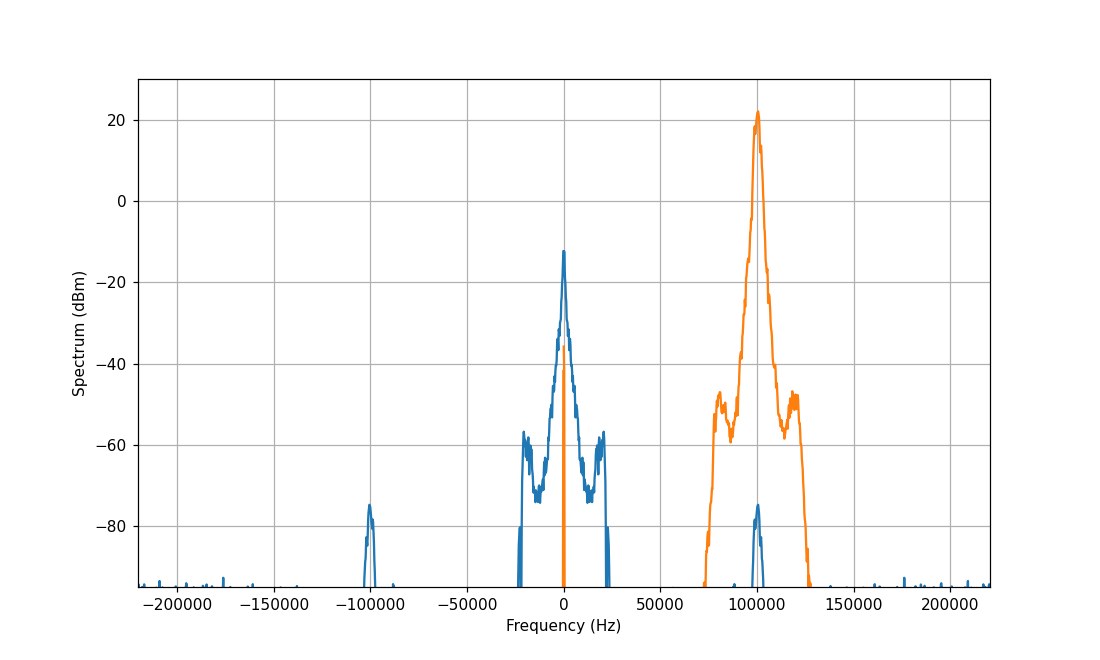

In [1]:
%matplotlib notebook
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import welch, resample_poly

signal_frame_size = 10000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 500        # число обрабатываемых пачек данных
rate_ratio = 10            # коэффициент увеличения частоты дискретизации
audio_amp = 1              # коэффициент усиления аудиосигнала
mod_index = '02'           # индекс модуляции ('02' = 0.2, '06' = 0.6, '1' = 1)

# открываем файл и получаем частоту дискретизации
signal_file = wave.open(f'../../wav/Audio_FM_ModIdx_{mod_index}.wav')
signal_fs = signal_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
audio_fs = signal_fs / rate_ratio
audio_frame_size = signal_frame_size / rate_ratio

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-95, 30)
ax.grid(True)

# создаем три линии для будущих графиков
for _ in range(2):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

# предыдущий отсчет в пачке    
last_sample = 0

message = []

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    fm_signal = signal_file.readframes(signal_frame_size)      # считываем отсчеты
    fm_signal = np.frombuffer(fm_signal, dtype=np.int16)       # преобразуем тип данных из byte в int16
    fm_signal = np.reshape(fm_signal, (-1, 2))                 # разделяем отсчеты для правого и левого канала
    fm_signal = (fm_signal[:,0] + 1j*fm_signal[:,1]) / 2**15   # выделяем комплексный сигнал и нормируем отсчеты к единице
    
    # вычисление разности фаз между отсчетами
    fm_signal_delayed = np.concatenate(([last_sample], fm_signal[0:-1]))
    phase_diff = np.angle(fm_signal * np.conj(fm_signal_delayed))
    last_sample = fm_signal[-1]
    
    # посторение спектрограмм
    signals = phase_diff, fm_signal
    
    for i in range(2):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=2048) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # удаление постоянной составляющей и уменьшение частоты дискретизации
    baseband_signal = phase_diff - phase_diff.mean()
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

sounddevice.play(message * audio_amp, audio_fs, blocking=True)

На спектрограмме желтым показан спектр частотно-модулированного сигнала, а синим - спектр восстановленного сообщения. На слух можно оценить, что сообщение восстанавливается без искажений.

## 3. Демодуляция FM-радио

Ниже представлен скрипт, позволяющий прослушивать FM-радио с помощью RTL-SDR. Настройка на нужную радиостанцию выполняется с помощью переменной Fc, которая задает частоту несущей. Входной сигнал проходит через фильтр нижных частот для выделения нужной радиостанции. Отфильтрованный сигнал поступает на Delay Line Detector. В заключение сигнал децимируется, у него удаляется постоянная составляющая и он подается на звуковую карту. 

In [ ]:
%matplotlib notebook
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice
import math
import time

import threading
from queue import Queue

from pylab import *
from rtlsdr import RtlSdr

from scipy.signal import welch, resample_poly, firls, lfilter

fc = 106.2e6                  # частота несущей в Hz
signal_fs = 1.2e6             # частота дискретизации RTL-SDR
audio_fs = 48e3               # частота дискретизации демодулированного аудиосигнала
signal_frame_size = 1024*16   # количество отсчетов чм-сигнала, получаемых за один раз
audio_amp = 0.1               # коэффициент усиления аудиосигнала
seconds = 3                   # количество записываемых секунд

# очереди для данных
queue_sample = Queue()
queue_audio = Queue()

# рассчет числа фреймов
decimation_rate = signal_fs / audio_fs
audio_frame_size = math.ceil(signal_frame_size / decimation_rate)
frames_number = int(seconds * audio_fs * decimation_rate / signal_frame_size)

# настройки RTL SDR
sdr = RtlSdr()
sdr.sample_rate = signal_fs
sdr.center_freq = fc
sdr.freq_correction = 10
sdr.gain = 'auto'

# получение отсчетов сигнала
def get_samples():    
    while True:
        queue_sample.put(sdr.read_samples(signal_frame_size))
        
# получение отсчетов сигнала
def play_sound():
    time.sleep(3)
    frame = 0
    message = np.zeros(frames_number * audio_frame_size)
    while True:
        message[frame*audio_frame_size : audio_frame_size*(frame+1)] = queue_audio.get()
        frame += 1
        if frame == frames_number:
            sounddevice.play(message, audio_fs, blocking=False)   
            frame = 0
               
# формирование полосового фильтра
H = firls(75, (0, 110e3, 160e3, signal_fs/2), (1, 1, 0, 0), fs=signal_fs)
FIR_tap_values = np.zeros(len(H) - 1)
t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

# запускаем сбор отсчетов
get_samples_tread = threading.Thread(target=get_samples)
play_sound_tread = threading.Thread(target=play_sound)
get_samples_tread.start()
play_sound_tread.start()

last_sample = 0
while True:
    # получаем фрейм отсчетов
    fm_signal_data = queue_sample.get()
    
    # удаление постоянной составляющей
    fm_signal_data = fm_signal_data - fm_signal_data.mean()

    # фильтрация
    filtered_data, FIR_tap_values = lfilter(H, 1.0, fm_signal_data, zi=FIR_tap_values)
    
    # вычисление разности фаз между отсчетами
    filtered_data_delayed = np.concatenate(([last_sample], filtered_data[0:-1]))
    phase_diff = np.angle(filtered_data * np.conj(filtered_data_delayed))
    last_sample = filtered_data[-1]
    
    # удаление постоянной составляющей и уменьшение частоты дискретизации
    baseband_data = phase_diff - phase_diff.mean()
    audio_data = resample_poly(baseband_data, 1, int(signal_fs/audio_fs))
   
    # отправляем данные на вывод
    queue_audio.put(audio_data * audio_amp)
         

Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


## Литература:
- B. P. Lathi Modern Digital and Analog Communication Systems 
- R. Stewart, K. Barlee, D. Atkinson, L. Crockett Software Defined Radio using MATLAB® & Simulink and the RTL-SDR